#### Algoritmo Butina utilizando Spark

Autor: Rennê Ruan Alves Oliveira

Link para o Google Colab: https://colab.research.google.com/drive/11ZA4bLbhNFt75kMpkRTgCCD39ZzNXZ8H?usp=sharing

Este projeto devemos criar o algoritmo de clusterização Butina almejando a escalabilidade para o crescimento da quantia de elementos, para que a execução seja em tempo hábil devemos utilizar estratégias de processamento paralelo.

Este projeto foi realizado utilizando Python 3.11.7 em máquina local, depois foi repassado para o Google Colab visando maior facilidade na visualização e execução


As duas células a seguir devem ser executadas caso a máquina de execução desse notebook não possua o Spark instalado


In [4]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
!pip install findspark

In [2]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Caso você já possua o spark instalado, basta executar a partir daqui.


In [1]:
import findspark
import numpy as np
from pyspark.storagelevel import StorageLevel
from pyspark import SparkConf, SparkContext

A seguir temos as configurações para o uso do Spark. Para o nosso problema, como não estamos trabalhando com dados grandes, mas sim com uma grande quantia de interações, precisamos abrir mão de uma execução paralela, mas não necessariamente distribuída (tanto pela necessidade quando pela não disponibilidade de clusters).O Spark foi configurado para utilizarmos todos os núcleos de CPU disponíveis para a execução, além disso as configurações padrão de partições foi sobrescrita, diminuindo o _overhead_ de necessidade de troca de informações para processar os dados paralelos.


In [2]:
findspark.init()

conf = (
    SparkConf()
    .setAppName("ButinaApp")
    .setMaster("local[*]")  # Utilização de todos os núcleos da CPU
    .set(
        "spark.sql.shuffle.partitions", "8"
    )  # Sobrescrita da quantia de partições de embaralhamento
    # O valor padrão é 200, porém para nosso volume de dados, isso geraria mais overhead do que desempenho
    .set(
        "spark.default.parallelism", "8"
    )  # Valor padrão de repartições de transformações
    # .set("spark.driver.memory", "6g")
)
# .set("spark.executor.memory", "6g") \

sc = SparkContext(conf=conf)

Criação das funções de apoio, utilizadas para construir a lista de vizinhos de acordo com a distância de Tanimoto.

A função `build_neighbours` será aplicada na etapa de paralelização, devido a isso está desacoplada da classe criada e construída em um escopo global.

O cálculo da função de Tanimoto da função `calculate_distance`, recebe os pontos como _arrays_ e calcula:

- B1: Todos os valores 1 para o array 1
- B2: todos os valores 1 para o array 2
- BC: Quantia de valores 1 presentes nas mesmas posições entre os vetores de entrada
- A similaridade é dada por BC / (B1 + B2 - BC) (A união entre B1 e B2 sobre o complemento)


In [3]:
def calculate_distance(first_point, second_point):
    """
    Função para cálculo de distância de Tanimoto

    Parâmetros:
    - first_point (list): Primeiro elemento dado pela lista de 0 ou 1
    - second_point (list): Segundo elemento dado pela lista de 0 ou 1

    Retornos:
    - similarity (float): Coeficiente de similaridade entre vetores/listas
    """
    a = np.array(first_point)
    b = np.array(second_point)
    b1 = (a == 1).sum()
    b2 = (b == 1).sum()
    bc = ((a == b) & (a == 1)).sum()

    similarity = bc / (b1 + b2 - bc)
    return similarity


def build_neighbours(i, points, similarity_cutoff):
    """
    Itera a partir de um índice recebido e verifica a similaridade
    entre os pontos vizinhos de cada índice adjacente.

    Parâmetros:
    - i (int): Índice que queremos analisar
    - points (list): Lista de pontos originais para cálculo da distância
    - similarity_cutoff (float): Limiar de similaridade para ser declarado como vizinho

    Retornos:
    - neighbours (list): Lista dos vizinhos do índice i recebido
    """

    neighbours = []
    for j in range(i):
        similarity = calculate_distance(points[i], points[j])
        if similarity <= similarity_cutoff:
            neighbours.append((i, j))
            neighbours.append((j, i))

    return neighbours

In [4]:
class ButinaClusterizer:
    """
    Classe com etapas do clusterizador não supervisionado Butina.
    """

    def __init__(self, input_points, similarity_cutoff, type):
        """
        Parâmetros:
        - input_points (list): lista de elementos contendo 166 bits a serem analisados
        - similarity_cutoff (float): Limiar de similaridade para ser declarado como vizinho
        - type (string): Tipo de execução "p" para paralela utilizando Spark ou "s" para execução sequencial
        """
        self.input_points = input_points
        self.similarity_cutoff = similarity_cutoff
        self.input_size = self.input_points.shape[0]
        self.neighbours = None
        self.sorted_top_neighbours = None

        self.__initialize_neighbours_list()

        # Verifica se é execução paralela ou sequencial
        if type == "p":
            self.__build_parallel_list()
        else:
            self.__build_sequencial_list()

        self.__sort_neighbours()
        self.__create_cluster()

    def __initialize_neighbours_list(self):
        """
        Criação de lista de vizinhos vazia de acordo com tamanho de entrada.
        """
        self.neighbours = np.empty(self.input_size, dtype=object)
        self.neighbours = {i: [] for i in range(self.input_size)}

    def __build_parallel_list(self):
        """
        Criação da lista de vizinhos de forma paralela utilizando Spark.
        """

        # Cria RDD particionando os índices que terão seus vizinhos analisados
        i_rdd = sc.parallelize(range(self.input_size), 8)  # 8 partições

        input_points = self.input_points
        cutoff = self.similarity_cutoff

        # Aplica o map ao RDD de índices em que cada thread irá realizar a contagem de
        # vizinhos da respectiva partição

        neighbours_pairs = i_rdd.flatMap(
            lambda i: build_neighbours(i, input_points, cutoff)
        ).persist(StorageLevel.MEMORY_AND_DISK)

        # Agrupa vizinhos a partir do primeiro elemento da tupla de adjacência
        # Com isso temos uma lista dos vizinhos de cada index
        neighbours_rdd = neighbours_pairs.groupByKey().mapValues(list).cache()

        self.neighbours = {k: list(v) for k, v in neighbours_rdd.collect()}

    def __build_sequencial_list(self):
        """
        Criação da lista de vizinhos de forma sequencial sem utilização do Spark.
        """

        for i in range(self.input_size):
            for j in range(i):
                distance = calculate_distance(
                    self.input_points[i], self.input_points[j]
                )

                if distance <= self.similarity_cutoff:
                    self.neighbours[i].append(j)
                    self.neighbours[j].append(i)

    def __sort_neighbours(self):
        """
        Ordena a lista de vizinhos para resgatar elementos candidatos a centróides.
        """
        self.top_neighbours = []

        for i, array in self.neighbours.items():
            self.top_neighbours.append((i, len(array)))

        self.sorted_top_neighbours = (
            sc.parallelize(self.top_neighbours, 8)  # 8 partições
            .sortBy(keyfunc=lambda x: x[1], ascending=False)
            .collect()
        )

        # self.sorted_top_neighbours = sorted(self.top_neighbours, key=lambda x: x[1])
        # self.sorted_top_neighbours.reverse()

    def __create_cluster(self):
        """
        Itera sobre lista de melhores candidatos agregando os índices
        aos clusters, esta fase apresenta uma complexidade mais simples
        que a criação da lista de vizinhos, não necessitando de paralelização.
        """

        already_used = np.full(self.input_size, False, dtype=bool)
        self.clusters = []

        while self.sorted_top_neighbours:
            # print(self.sorted_top_neighbours)
            centroid_index, _ = self.sorted_top_neighbours.pop(0)

            if not already_used[centroid_index]:
                cluster_list = []

                for neighbour_index in self.neighbours[centroid_index]:
                    if not already_used[neighbour_index]:
                        cluster_list.append(neighbour_index)
                        already_used[neighbour_index] = True

                self.clusters.append((centroid_index, cluster_list))

    def show_clusters(self):
        """
        Imprime os Clusters criados ao final das operações.
        """

        for c, a in self.clusters:
            print(f"Centróide: {c} com {len(a)} vizinhos.")

        # print(self.clusters)

Iremos criar uma lista de 10 mil elementos contendo 166 valores de 0 a 1


In [5]:
num_elements = 10000
fingerprint_dimension = 166

array = np.random.randint(2, size=(num_elements, fingerprint_dimension))

O _cutoff_ escolhido para resultar em uma diversidade na clusterização foi de 0.32, tendo em vista a utilização da randomização de 0 ou 1 pela função do numpy, assumindo uma porcentagem de 50% para cada posição dos 166 valores, temos uma dificuldade na correspondência bit a bit de cada elemento, a alteração desse cutoff de similaridade para valores maiores geraria um único cluster contendo a maioria ou todos os elementos.


A execução do algoritmo utilizado o paralelismo do Spark em ambiente local utiliza majoritariamente as diferentes Threads do núcleo de processador, uma vez que não há a possibilidade de utilização de clusters distribuídos, além de estarmos lidando com um volume de dados (em tamanho) pequeno. O tempo de execução utilizando o Spark ficou entre 6:30 a 7 minutos.

A utilização do Google colab para este algoritmo não apresenta uma otimização satisfatória, uma vez que ele fornece apenas a quantia adicional 1 de núcleo de CPU (totalizando 2), sendo menor que a do computador local. Ou seja, com o Google Colab, a paralelização pela threads, tendo em vista que os arquivos não apresnetam tamanho grande não foi facilmente visualizada.


In [6]:
parallelClusterizer = ButinaClusterizer(array, 0.32, "p")
parallelClusterizer.show_clusters()

Centróide: 8697 com 9490 vizinhos.
Centróide: 9847 com 350 vizinhos.
Centróide: 1711 com 86 vizinhos.
Centróide: 90 com 19 vizinhos.
Centróide: 2451 com 9 vizinhos.
Centróide: 4914 com 4 vizinhos.
Centróide: 2391 com 1 vizinhos.
Centróide: 230 com 0 vizinhos.
Centróide: 1891 com 1 vizinhos.
Centróide: 3322 com 0 vizinhos.
Centróide: 9005 com 0 vizinhos.
Centróide: 9634 com 1 vizinhos.
Centróide: 6819 com 1 vizinhos.
Centróide: 7006 com 0 vizinhos.
Centróide: 5194 com 0 vizinhos.
Centróide: 1952 com 0 vizinhos.
Centróide: 5660 com 0 vizinhos.
Centróide: 9456 com 0 vizinhos.
Centróide: 1937 com 0 vizinhos.
Centróide: 4435 com 0 vizinhos.
Centróide: 2952 com 0 vizinhos.
Centróide: 1091 com 0 vizinhos.
Centróide: 5618 com 0 vizinhos.
Centróide: 9309 com 0 vizinhos.
Centróide: 2308 com 0 vizinhos.
Centróide: 7891 com 0 vizinhos.
Centróide: 4230 com 0 vizinhos.
Centróide: 2323 com 0 vizinhos.
Centróide: 8951 com 0 vizinhos.
Centróide: 3358 com 0 vizinhos.
Centróide: 9697 com 0 vizinhos.
Cent

Já para a execução sequencial, em ambiente local tendo em vista a utilização de um único núcleo foi finalizada em aproximadamente 12-13 minutos, praticamente o dobro de tempo do que o utilizado pelo Spark.


In [7]:
sequencialClusterizer = ButinaClusterizer(array, 0.32, "s")
sequencialClusterizer.show_clusters()

Centróide: 8697 com 9490 vizinhos.
Centróide: 9847 com 350 vizinhos.
Centróide: 1711 com 86 vizinhos.
Centróide: 90 com 19 vizinhos.
Centróide: 2451 com 9 vizinhos.
Centróide: 2391 com 1 vizinhos.
Centróide: 4914 com 4 vizinhos.
Centróide: 230 com 0 vizinhos.
Centróide: 1891 com 1 vizinhos.
Centróide: 3322 com 0 vizinhos.
Centróide: 9005 com 0 vizinhos.
Centróide: 9634 com 1 vizinhos.
Centróide: 6819 com 1 vizinhos.
Centróide: 7006 com 0 vizinhos.
Centróide: 5194 com 0 vizinhos.
Centróide: 1952 com 0 vizinhos.
Centróide: 5660 com 0 vizinhos.
Centróide: 9456 com 0 vizinhos.
Centróide: 1937 com 0 vizinhos.
Centróide: 4435 com 0 vizinhos.
Centróide: 2952 com 0 vizinhos.
Centróide: 1091 com 0 vizinhos.
Centróide: 5618 com 0 vizinhos.
Centróide: 9309 com 0 vizinhos.
Centróide: 2308 com 0 vizinhos.
Centróide: 7891 com 0 vizinhos.
Centróide: 4230 com 0 vizinhos.
Centróide: 2323 com 0 vizinhos.
Centróide: 8951 com 0 vizinhos.
Centróide: 3358 com 0 vizinhos.
Centróide: 9697 com 0 vizinhos.
Cent

In [19]:
# Encerramento da sessão do Spark
sc.stop()

Abaixo seguem imagens de exemplo com o código rodado em máquina local.


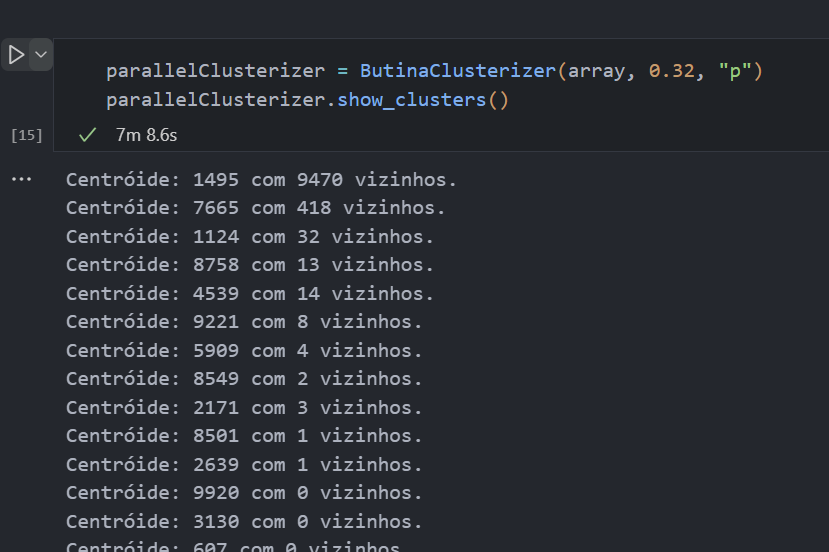

In [ ]:
from IPython.display import Image

Image("/content/exec-p.png")

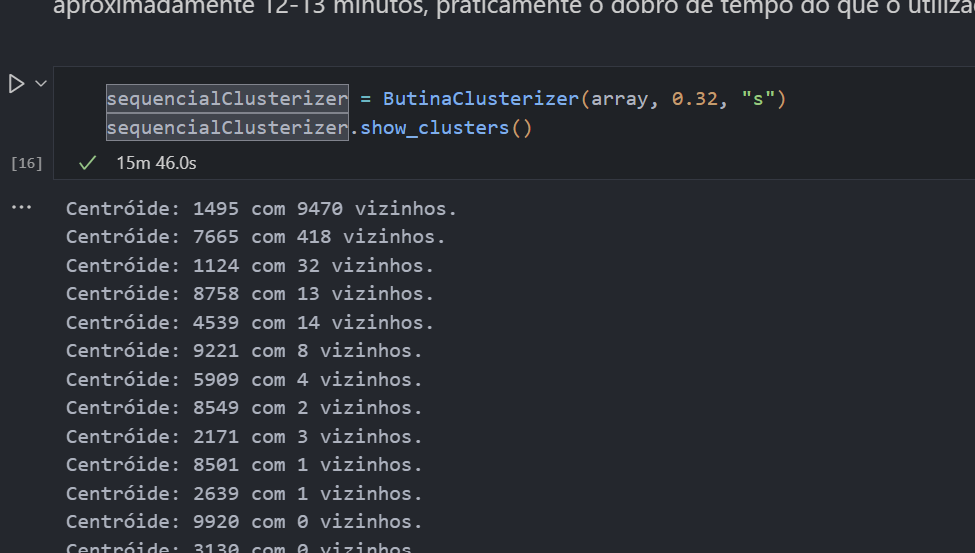

In [ ]:
from IPython.display import Image

Image("/content/exec-s.png")